In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
df_train = pd.read_csv('./train.csv')

In [19]:
#Extend the df by splitting the datetime into new categories
df_train['year'] = df_train.datetime.apply(lambda x: x.split()[0].split('-')[0]).astype(str).astype(int)
df_train['month'] = df_train.datetime.apply(lambda x: x.split()[0].split('-')[1]).astype(str).astype(int)
df_train['day'] = df_train.datetime.apply(lambda x: x.split()[0].split('-')[2]).astype(str).astype(int)
df_train['hour'] = df_train.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype(str).astype(int)

#Infer Day Name
sr = pd.to_datetime(df_train['datetime']) 
df_train['Day_name'] = sr.dt.day_name()

#Season List 
season_dict = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
df_train['Season_Exp'] = df_train['season'].map(season_dict)

#Weather List
weather_dict = {1:'clear' , 2:'mist' , 3:'light_precip' , 4: 'heavy_precip' }
df_train['Weather_Exp'] = df_train['weather'].map(weather_dict)

#Season Reconvert
new_season = {'Spring': 1, 'Winter': 2, 'Summer': 3, 'Fall': 4}
df_train['Season_Reconvert'] = df_train['Season_Exp'].map(new_season)

#Day Reconvert
day_new = {'Sunday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Monday': 4, 'Friday': 5, 'Thursday': 6, 'Saturday': 7}
df_train['Day_Reconvert'] = df_train['Day_name'].map(day_new)

#Year Reconvert
year_new = {2011: 1, 2012: 2}
df_train['Year_Reconvert'] = df_train['year'].map(year_new)

#Hour Binning
#hour_range = range(0,24)
#bins = ['Night']*6 + ['Morning']*4 + ['Day']*7 + ['Evening']*7
#hour_new = dict(zip(hour_range, bins))
#df_train['Hour_binned'] = df_train['hour'].map(hour_new)

#Hour_Dict_Factorization_Low Level
#factor_hour = {'Night': 0, 'Morning':1, 'Day': 2, 'Evening': 3}
#df_train['Hour_Reconvert'] = df_train['Hour_binned'].map(factor_hour)


In [20]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,day,hour,Day_name,Season_Exp,Weather_Exp,Season_Reconvert,Day_Reconvert,Year_Reconvert,hour_3,hour_2
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,1,0,Saturday,Spring,clear,1,7,1,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,1,1,Saturday,Spring,clear,1,7,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,1,2,Saturday,Spring,clear,1,7,1,8,4
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,1,3,Saturday,Spring,clear,1,7,1,27,9
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,4,Saturday,Spring,clear,1,7,1,64,16


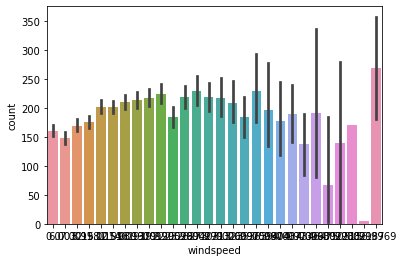

In [32]:

sns.barplot(x = 'windspeed', y = 'count', data = df_train)

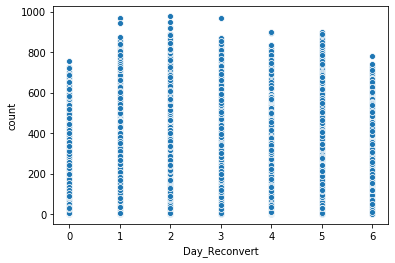

In [37]:
# Polynomial Feature Single Fitting
#


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
pipeline = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression()
)
pipeline.fit(df_train[['windspeed']], df_train[['count']])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [38]:
pipeline.score(df_train[['windspeed']], df_train[['count']])

0.013746551665356986

In [39]:
df_train['hour_3'] = df_train['hour']**3
df_train['hour_2'] = df_train['hour']**2
df_train['season_2'] = df_train['season']**2
df_train['weather_2'] = df_train['weather']**2
df_train['windspeed_2'] = df_train['windspeed']**2


In [50]:
#Define Xtrain and ytrain
Xtrain = df_train[['hour_2','hour_3', 'atemp','Year_Reconvert', 'season_2', 'weather_2', 'windspeed_2']]
#Xtrain = Xsub.values.reshape(-1,1)

#Convert ytrain to log1p because you need to collapse the count numbers across all scales of x
ytrain = df_train['count']

In [52]:
m = LinearRegression()
m.fit(Xtrain, ytrain)
ypred = m.predict(Xtrain)
print(mean_squared_error(ytrain, ypred)) #Scikit
print(m.score(Xtrain, ytrain))

15333.195281400134
0.5326712708541267


In [53]:
m.coef_ , m.intercept_, Xtrain.columns
l = zip(Xtrain.columns, m.coef_)
fit_coeff = pd.DataFrame(l, columns = ['Variables', 'Coefficients'], index = Xtrain.columns)
fit_coeff.drop('Variables', axis = 1)

,Coefficients
hour_2,3.547633
hour_3,-0.148688
atemp,5.067105
Year_Reconvert,89.306807
season_2,3.170166
weather_2,-18.469287
windspeed_2,-0.009889
weather,35.287820


In [54]:
from scipy.stats import probplot
import matplotlib.pyplot as plt



-1.225898350721284e-13


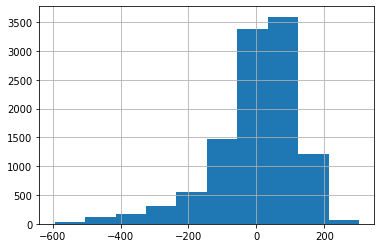

In [55]:
#Check the assumptions
#Mean residual is around zero
residuals = ypred - ytrain
print(residuals.mean())
residuals.hist()


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([-593.75659746, -583.95989402, -581.99144066, ...,  263.76679979,
          285.16981057,  301.80212893])),
 (118.53932105197813, -1.5803936388653503e-13, 0.9569784752962315))

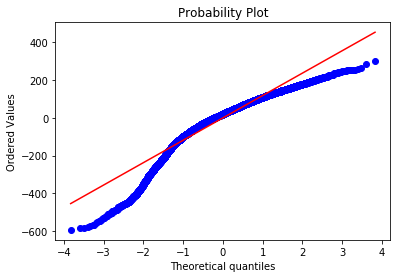

In [56]:
#Q-Q plot
probplot(residuals, plot=plt)

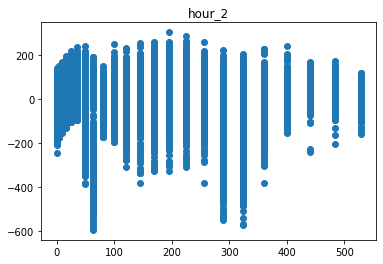

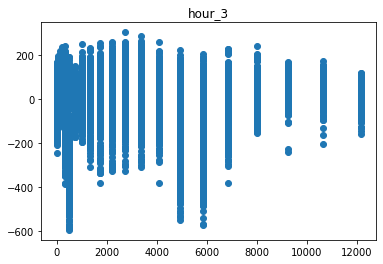

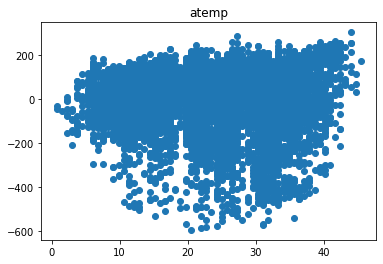

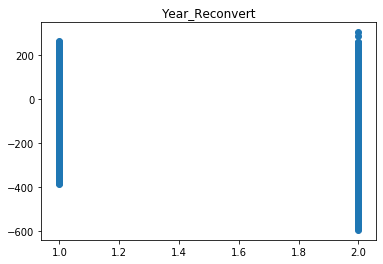

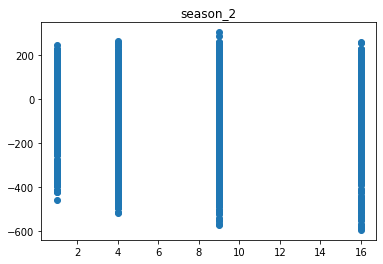

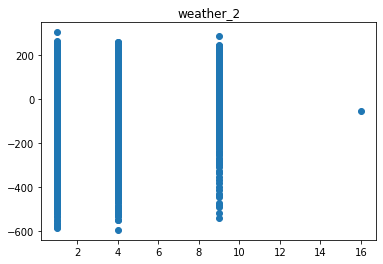

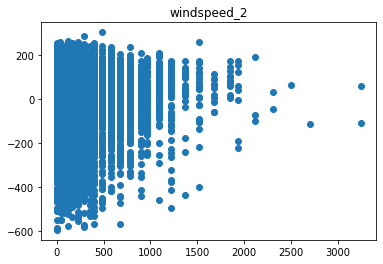

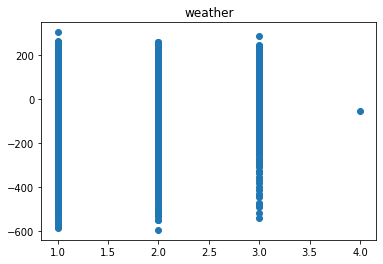

In [57]:
#Residuals uncorrelated with x and must be equally on and under 0

for column in Xtrain.columns:
    plt.scatter(Xtrain[column], residuals)
    plt.title(f'{column}')
    plt.show()
#plt.scatter(Xtrain, residuals)
#Xtrain.shape, residuals.shape